In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.image import rgb_to_grayscale
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import os

In [2]:
mannequin_path = os.path.join('../','mannequin_filter')
not_mannequin_path = os.path.join('../','not_mannequin_filter')

mannequin_img_path = [os.path.join(mannequin_path,x) for x in os.listdir(mannequin_path)]
not_mannequin_img_path = [os.path.join(not_mannequin_path,x) for x in os.listdir(not_mannequin_path)]

print(mannequin_img_path[:5])
print(not_mannequin_img_path[:5])

random.shuffle(mannequin_img_path)
random.shuffle(mannequin_img_path)
random.shuffle(not_mannequin_img_path)
random.shuffle(not_mannequin_img_path)

print(mannequin_img_path[:5])
print(not_mannequin_img_path[:5])

['../mannequin_filter/176.jpg', '../mannequin_filter/1234.jpg', '../mannequin_filter/229.jpg', '../mannequin_filter/112.jpg', '../mannequin_filter/457.jpg']
['../not_mannequin_filter/176.jpg', '../not_mannequin_filter/1234.jpg', '../not_mannequin_filter/229.jpg', '../not_mannequin_filter/112.jpg', '../not_mannequin_filter/457.jpg']
['../mannequin_filter/312.jpg', '../mannequin_filter/854.jpg', '../mannequin_filter/64.jpg', '../mannequin_filter/106.jpg', '../mannequin_filter/1082.jpg']
['../not_mannequin_filter/819.jpg', '../not_mannequin_filter/556.jpg', '../not_mannequin_filter/88.jpg', '../not_mannequin_filter/591.jpg', '../not_mannequin_filter/450.jpg']


In [3]:
train_mannequin_img, test_mannequin_img = train_test_split(mannequin_img_path,test_size = 0.25,random_state=42)
train_mannequin_img, val_mannequin_img = train_test_split(train_mannequin_img,test_size = 0.25,random_state=42)


In [4]:
test_not_mannequin_img,val_not_mannequin_img = train_test_split(not_mannequin_img_path,test_size = 0.25, random_state=42)

In [5]:
def generate_label_list(path,test_img_path):
    
    label_list = []
    for x in path:
        if x in test_img_path:
            label_list.append(1)
        else:
            label_list.append(0)
    return label_list

In [6]:
all_test_paths = test_mannequin_img + test_not_mannequin_img
random.shuffle(all_test_paths)
test_label_list = generate_label_list(all_test_paths,test_mannequin_img)

all_val_paths = val_mannequin_img + val_not_mannequin_img
random.shuffle(all_val_paths)
val_label_list = generate_label_list(all_val_paths,val_mannequin_img)


In [7]:
print(test_label_list[-8:])
print(all_test_paths[-8:])

[0, 1, 0, 1, 0, 0, 0, 0]
['../not_mannequin_filter/90.jpg', '../mannequin_filter/255.jpg', '../not_mannequin_filter/901.jpg', '../mannequin_filter/1157.jpg', '../not_mannequin_filter/674.jpg', '../not_mannequin_filter/141.jpg', '../not_mannequin_filter/652.jpg', '../not_mannequin_filter/748.jpg']


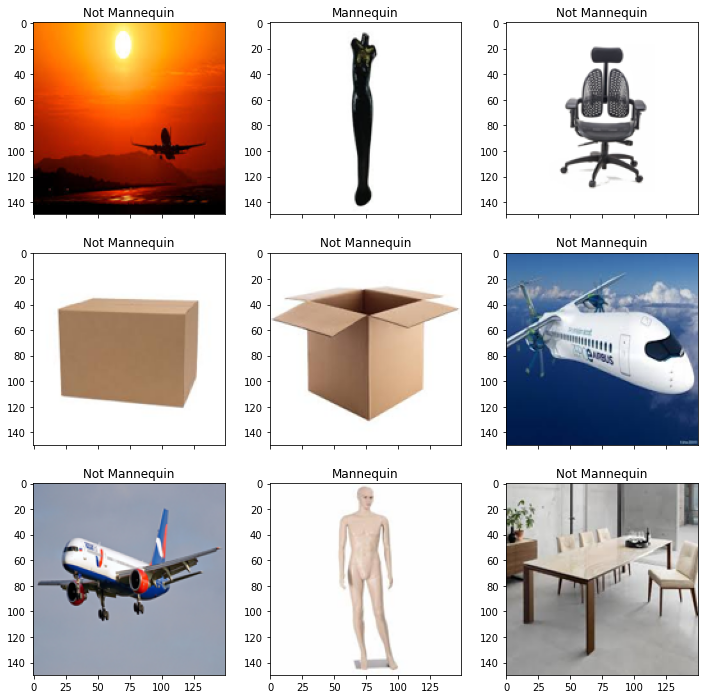

In [8]:
fig,axes = plt.subplots(3,3,sharex=True,figsize=(12,12))
for ax in axes.ravel():
    label = 'Not Mannequin'
    img = np.random.choice(all_test_paths)
    temp = img.split('/')
    label = 'Not Mannequin' if temp[1][0] == 'n' else 'Mannequin'
    img = load_img(img,target_size=(150,150),interpolation='bicubic')
    ax.imshow(img)
    ax.set_title(label)




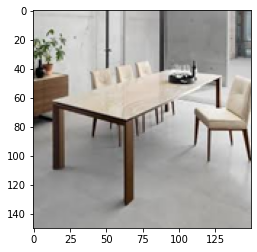

In [9]:
a = img_to_array(img)
a = a/255
# a = a.astype(np.uint8)
plt.imshow(a)

In [10]:
image_size = 150
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width),interpolation='bicubic') for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)


In [11]:
X_train = read_and_prep_images(train_mannequin_img)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)


In [12]:
X_test.shape

(1248, 150, 150, 3)

In [13]:
resnet_model = ResNet50(include_top = False, weights='imagenet',input_shape=(150,150,3))
resnet_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(resnet_model.output)
model = tf.keras.Model(resnet_model.input,x)
# model = resnet_model

In [14]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [15]:
train = resnet_model.predict(X_train)
test = resnet_model.predict(X_test)
X_train = model.predict(X_train)
X_test = model.predict(X_test)
X_val = model.predict(X_val)


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm

In [18]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.99


In [19]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.00001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

In [20]:
oc_svm_preds


array([ 1, -1, -1, ..., -1, -1, -1])

In [21]:
if_preds[0:10]

array([ 1, -1, -1,  1, -1, -1, -1, -1, -1, -1])

In [22]:
if_preds_modified = []
for i in range(len(if_preds)):
    if if_preds[i] == -1:
        if_preds_modified.append(0)
        
    else:
        if_preds_modified.append(1)

oc_svm_pred_modified = []
for i in range(len(oc_svm_preds)):
    if oc_svm_preds[i] == -1:
        oc_svm_pred_modified.append(0)
        
    else:
        oc_svm_pred_modified.append(1)


In [23]:
print(roc_auc_score(test_label_list,if_preds_modified))

0.811965811965812


In [24]:
print(roc_auc_score(test_label_list,oc_svm_pred_modified))

0.8349358974358974


In [25]:
print(oc_svm_clf.score_samples(X_test))

[55.55032438 54.96209747 55.27622356 ... 54.9556013  55.30704105
 53.21118214]
